# Goal

The idea of this notebook is to correct the drift the image in order to be able to quantify the image better. Also I want a visual display of the drift

## Import the necessary packages

In [5]:
import skimage
import napari
from tifffile import imread,imwrite
from pathlib import Path
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.measure as sm
import seaborn as sns
import os
from scipy.optimize import curve_fit
from skimage.measure import label, regionprops, regionprops_table
from scipy import ndimage
from matplotlib import animation
from IPython.display import HTML
import matplotlib as cm
from skimage.segmentation import morphological_chan_vese,checkerboard_level_set
from skimage.filters import rank,gaussian
from skimage.morphology import disk
from skimage import exposure
from skimage import img_as_float
from matplotlib.patches import Circle

### Load a "raw image"

In [265]:
path = Path('../data/tricho_wound.tif')
im = imread(path)[700:800,...].astype('uint16')
print(np.shape(im))

(100, 576, 576)


In [64]:
def plotting(n_row,n_col,img,plane):
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for plane, ax in zip(plane, axs):
        ax.imshow(img[plane])#,cmap='gray')
        #c = Circle((23,112),15,fill=False,edgecolor='red')
        #ax.add_patch(c)
        ax.axis('off')
    _.tight_layout()
    return axs

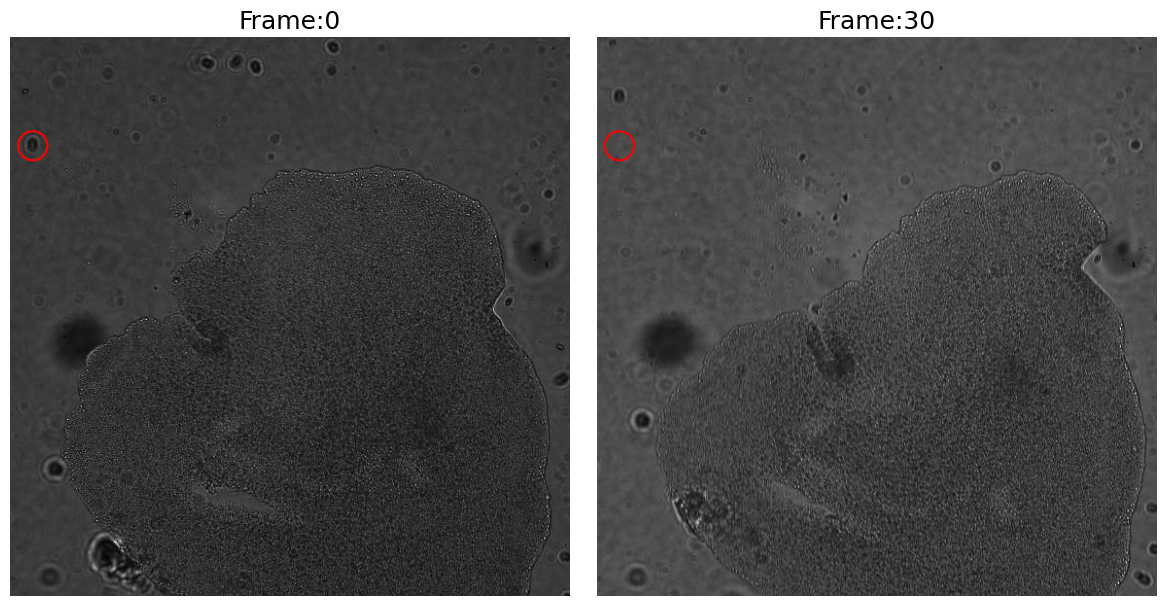

In [42]:
sns.set_context('talk')
m = plotting(1,2,im,[0,30])

title = [0,30]

for i,ax in enumerate(m):
    ax.set_title(f'Frame:{title[i]}')
    
    
plt.savefig('../data/results/figures/drift_correction/drift.png',dpi=300)

# Segmenting the algae on projected image

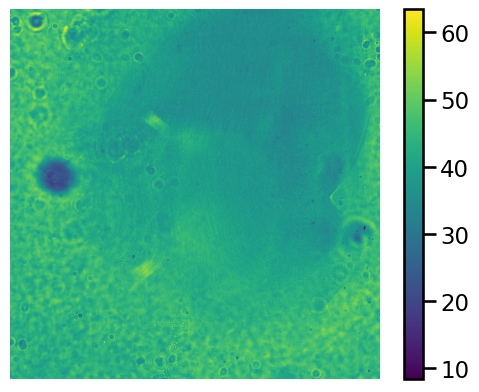

In [43]:
#projecting the image in order to average all plane and get the position of the static elements

im_p = np.mean(im,axis=0)
plt.axis('off')
plt.imshow(im_p,origin='lower')
plt.colorbar()
plt.show()


In [44]:
# segment 
def segm_alg(im_p):
    #gaussian blurr
    image = gaussian(im_p,sigma=1)
    #image = im_p
    #segment using also a smoothing
    im_ms = morphological_chan_vese(image,num_iter=20,smoothing=2)
    
    #fill holes and dilate to remove noise
    ms_filled = ndimage.binary_fill_holes(im_ms)
    ms_filled = ndimage.binary_dilation(ms_filled)
    #ms_filled = im_ms
    
    #label connected components in the binary mask
    labels, num_features = ndimage.label(ms_filled)
    label_unique = np.unique(labels)

    #count pixels of each component and sort them by size, excluding the background
    vol_list = []
    for label in label_unique:
        if label != 0:
            vol_list.append(np.count_nonzero(labels == label))

    #create binary array of only the largest component
    binary_mask = np.zeros(labels.shape)
    binary_mask = np.where(labels == vol_list.index(max(vol_list))+1, 1, 0)
    #binary_mask = np.where(labels == vol_list.index(min(vol_list))+1, 1, 0)

    
    #remove the largest component from the image
    
    m = ms_filled - binary_mask
    
    #m = binary_mask
    
    return m

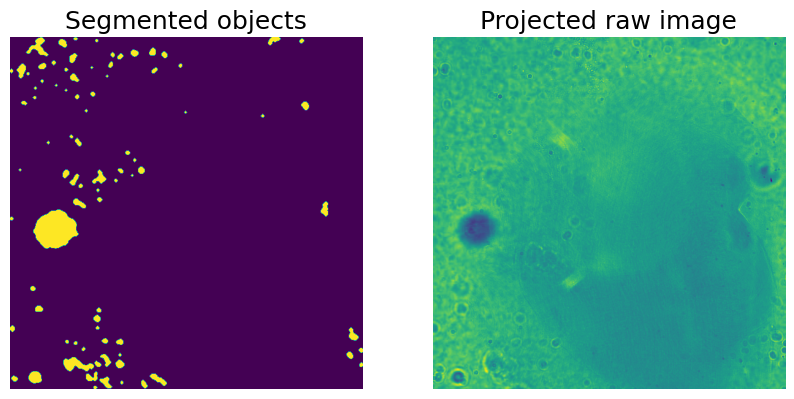

In [45]:
m = segm_alg(im_p)

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(m)
ax[1].imshow(im_p)

l = ['Segmented objects','Projected raw image']

for j,ax in enumerate(ax):
    ax.axis('off')
    ax.set_title(l[j])
plt.show()

In [46]:
lab = label(m)
props = regionprops_table(label_image=lab, intensity_image = im_p, properties=('centroid','area','slice','intensity_mean'))

df = pd.DataFrame(props)
df#.head()

centroid-0  centroid-1  area  \
0     6.035503  429.751479   169   
1    17.800000   45.720879   455   
2     4.000000  106.500000    28   
3     7.500000  475.500000    46   
4    11.194245   85.697842   139   
..         ...         ...   ...   
79  558.666667    6.960000    75   
80  564.839806  156.174757   206   
81  567.812500  218.406250    96   
82  565.000000  182.000000    23   
83  573.000000  138.629630    27   

                                             slice  intensity_mean  
0      (slice(0, 15, None), slice(421, 442, None))       40.549763  
1        (slice(2, 33, None), slice(26, 63, None))       40.441187  
2       (slice(2, 7, None), slice(103, 111, None))       40.021786  
3      (slice(4, 12, None), slice(472, 480, None))       40.272174  
4        (slice(5, 19, None), slice(79, 93, None))       39.765036  
..                                             ...             ...  
79     (slice(554, 564, None), slice(2, 13, None))       38.164933  
80  (slice(556, 575, None), slice(146, 167, None))       40.018641  
81  (slice(561, 575, None), slice(214, 225, None))       40.654687  
82  (slice(562, 569, None), slice(180, 185, None))       39.500000  
83  (slice(571, 576, None), slice(136, 143, None))       38.494074  

[84 rows x 5 columns]

AxesSubplot(0.31875,0.11;0.0341912x0.77)


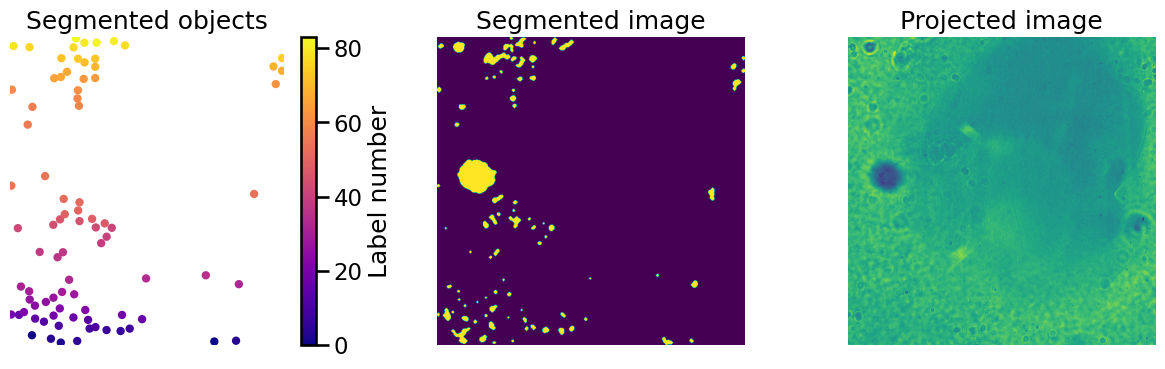

In [47]:
sns.set_context("talk")

fix,ax = plt.subplots(1,3,figsize=(15,4),sharex=True,sharey=True)

c = [x for x in df.index.values]

s = ax[0].scatter(df['centroid-1'],df['centroid-0'],marker='.',c=c,cmap='plasma')
ax[1].imshow(m,origin='lower')
ax[2].imshow(im_p,origin='lower')

title = ['Segmented objects','Segmented image','Projected image']

fig.colorbar(s, ax=ax[0])

for ax,t in zip(ax,title):
    ax.axis('off')
    ax.set_title(t)
    
f = plt.gcf()

cax = f.get_axes()[-1]
print(cax)
cax.set_ylabel('Label number')
fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/algea_detection_automatic.png',dpi=300)
plt.show()

The problem is that on a projection the position of the algae is averaged when there is movement so you can't correct the drift

## Test to remove the algae

In [266]:
mask = imread('../data/results/chan_vese/placozoan-movie_wound_masked_chanvese.tif')[700:800,...]

random color map:

viridis = cm.colormaps['viridis'].resampled(len(position.index))


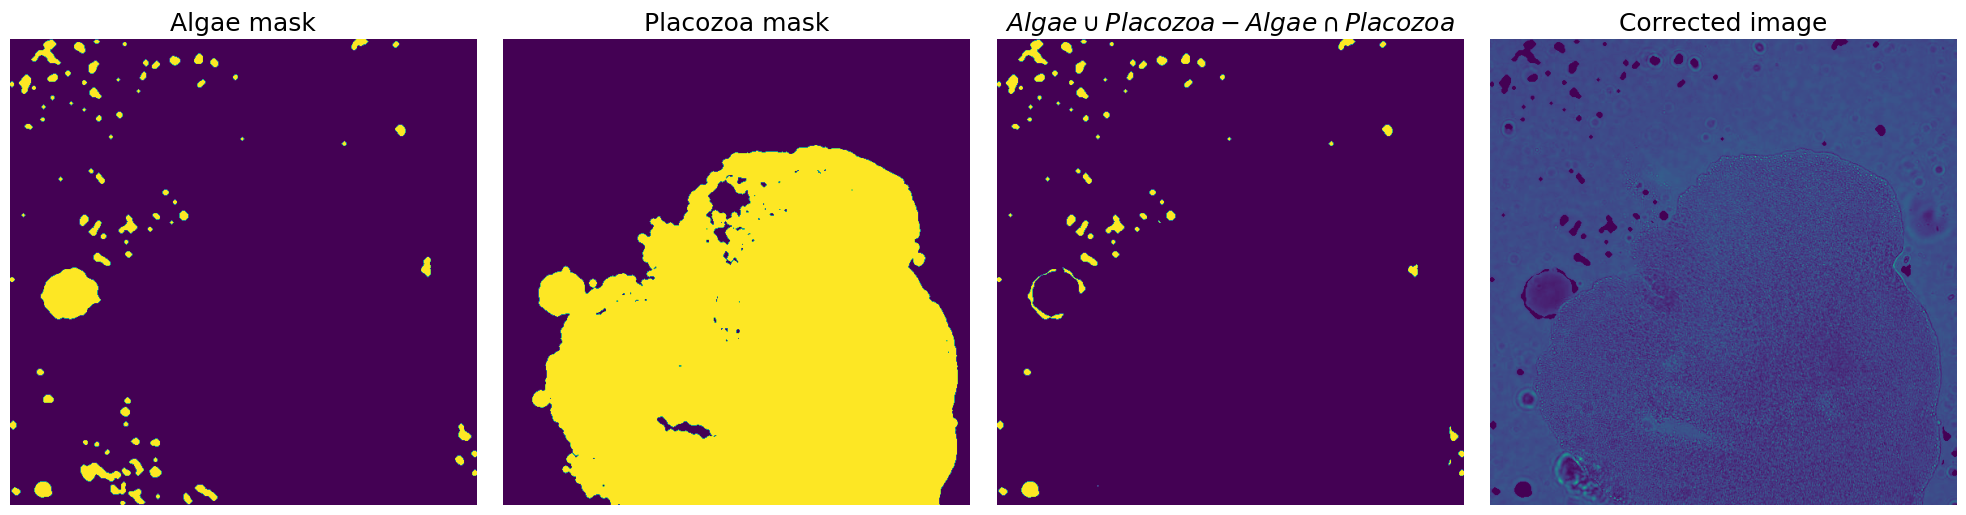

In [117]:
sns.set_context("talk")
fig,ax = plt.subplots(1,4, figsize=(20,7))

#create the mask by subtracting the algae and the environment

ma = m.copy()

mask_img = ma * (mask[3,...] == 0.)

#correct the image based on the substraction

im_test = im[3,...].copy()

newImage = im_test * (mask_img==0)

# plot 

ax[0].imshow(ma)
ax[1].imshow(mask[3,...])
ax[2].imshow(mask_img)
ax[3].imshow(newImage)

lab = ['Algae mask','Placozoa mask','$Algae\cup Placozoa - Algae\cap Placozoa$','Corrected image']
for k,ax in enumerate(ax):
    ax.set_title(lab[k])
    ax.axis('off')
    
fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/algea_removal_automatic_proof_of_concept.png',dpi=300)

In [118]:
def correct(mask_alg,mask_plac,raw_img):
    
    #initialize the corrected raw image
    
    new_image = np.zeros_like(raw_img) 
    
    for plane in range(np.shape(raw_img)[0]):
        
        #create the mask by subtracting the algae and the environment

        mask_img = mask_alg * (mask_plac[plane,...] == 0.)

        #correct the image based on the substraction

        new_image[plane,...] = raw_img[plane,...] * (mask_img == 0.)
        
        new_image[plane,...][new_image[plane,...] == 0] = 50 # change the value of the algae by 50 (arbitrary)
        
    #'''
        
    return new_image

In [119]:
def getalg(mask_alg,mask_plac,raw_img):
    '''
    get the algae for each plane that doesn't intersect with the organism
    for each plane tak only the difference between the mask of organism and mask of algaes
        
    '''
    #initialize the corrected raw image
    
    mask_img = np.zeros_like(raw_img) 
    
    for plane in range(np.shape(raw_img)[0]):
        
        #create the mask by subtracting the algae and the environment
        mask_img[plane,...] = mask_alg * (mask_plac[plane,...] == 0.)

    return mask_img

In [120]:
contr = getalg(ma,mask,im)

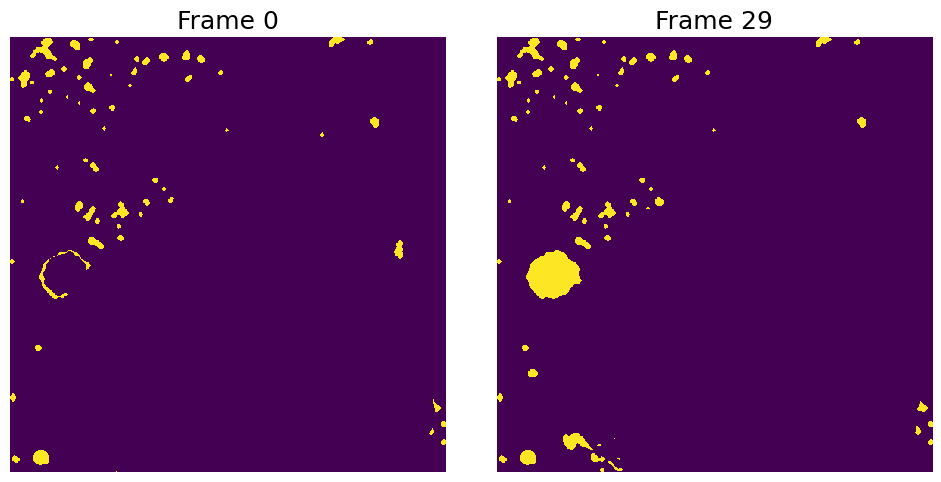

In [121]:
fig,ax = plt.subplots(1,2, figsize=(10,5))

for i,ax in zip([ 1 ,30],ax):
    ax.imshow(contr[i,...], interpolation='nearest')
    ax.set_title(f'Frame {i-1}')
    ax.axis('off')
    
fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/algea_removal_automatic_corrected_image.png',dpi=300)

## New idea 

The idea is to remove the organism from the image using the mask and then segment the algae to have them at time t

#### creating the removed image

In [50]:
im_test = im[3,...].copy()

new_image = im_test * (mask[3,...]==0.)

new_image[new_image == 0] = np.mean(im_test)


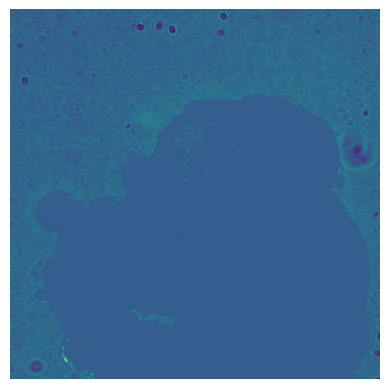

In [51]:
figures_folder = '../data/results/figures/drift_correction/'

# Create the folder if not existant

if os.path.isdir(figures_folder) != True:
    os.mkdir(figures_folder)


plt.imshow(new_image)
plt.axis('off')
#plt.savefig(figures_folder+'organism_removal.png',dpi=300)
plt.show()

In [71]:
def segm_alg(im_p):
    #gaussian blurr
    image = gaussian(im_p,sigma=2)
    
    #segment using also a smoothing
    im_ms = morphological_chan_vese(image,num_iter=20,smoothing=2)
    
    #fill holes and dilate to remove noise
    ms_filled = ndimage.binary_fill_holes(im_ms)
    ms_filled = ndimage.binary_dilation(ms_filled)
    
    #label connected components in the binary mask
    labels, num_features = ndimage.label(ms_filled)
    label_unique = np.unique(labels)

    #count pixels of each component and sort them by size, excluding the background
    vol_list = []
    for label in label_unique:
        if label != 0:
            vol_list.append(np.count_nonzero(labels == label))
            
    #create binary array of only the largest component
    binary_mask = np.zeros(labels.shape)
    binary_mask = np.where(labels == vol_list.index(max(vol_list))+1, 1, 0)
    
    #remove the largest component
    m = ms_filled - binary_mask
    
    return m

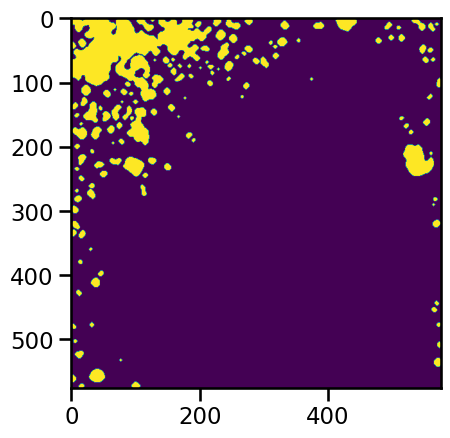

In [74]:
plt.imshow(segm_alg(new_image))

In [52]:
def alg(im,mask):
    
    '''
    Function to get the algae per plane:
    workflow:
        - remove the organism from the image
        - segment
        - remove largest component (also the organism but it also removes the algae that are under the organism)
        - return the segmented image 
    Inputs:
        - raw image
        - plane to segment
        - corresponding mask of the organim
    '''
    
    im_final = np.zeros_like(im)
    
    assert np.shape(im)[0] == np.shape(mask)[0]
    
    for plane in range(np.shape(im)[0]):
        
        im_test = im[plane,...].copy()

        new_image = im_test * (mask[plane,...]==0.)

        new_image[new_image == 0] = np.mean(im_test)

        #gaussian blurr
        image = gaussian(new_image,sigma=2)

        #segment using also a smoothing
        im_ms = morphological_chan_vese(image,num_iter=20,smoothing=2)

        #fill holes and dilate to remove noise
        ms_filled = ndimage.binary_fill_holes(im_ms)
        ms_filled = ndimage.binary_dilation(ms_filled)

        #label connected components in the binary mask
        labels, num_features = ndimage.label(ms_filled)
        label_unique = np.unique(labels)

        #count pixels of each component and sort them by size, excluding the background
        vol_list = []
        for label in label_unique:
            if label != 0:
                vol_list.append(np.count_nonzero(labels == label))

        #create binary array of only the largest component
        binary_mask = np.zeros(labels.shape)
        binary_mask = np.where(labels == vol_list.index(max(vol_list))+1, 1, 0)

        #remove the largest component
        m = ms_filled - binary_mask
        
        im_final[plane,...] = m
        
    return im_final

### I'm using the frames 718 to 748 because it's where there is drift

In [53]:
img = im[18:46,...]
ma = mask[18:46,...]

In [54]:
n = alg(img,ma)

In [55]:
np.shape(n)

(28, 576, 576)

### Plotting the results

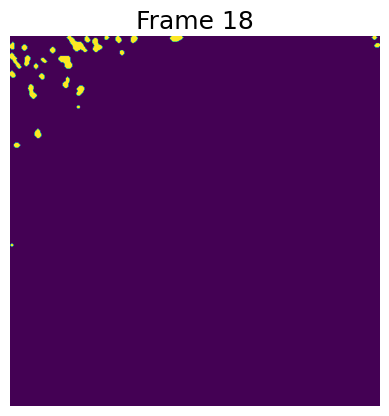

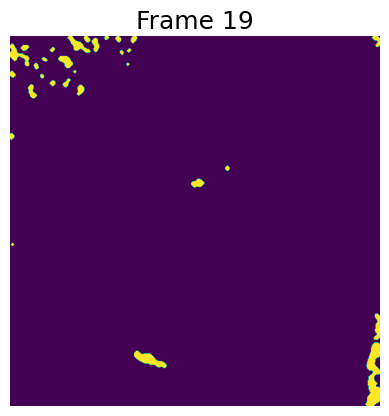

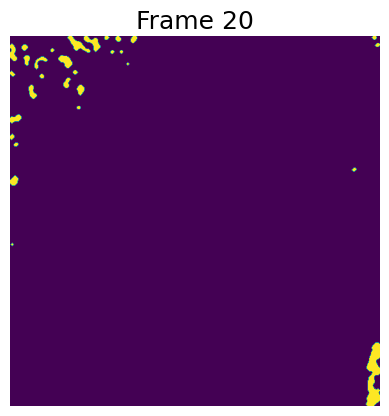

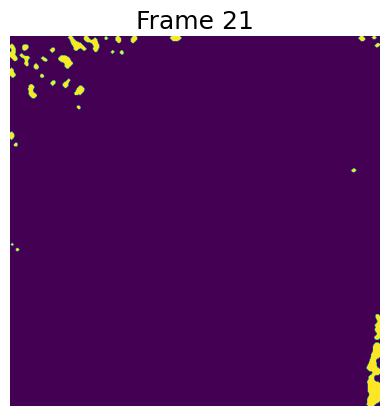

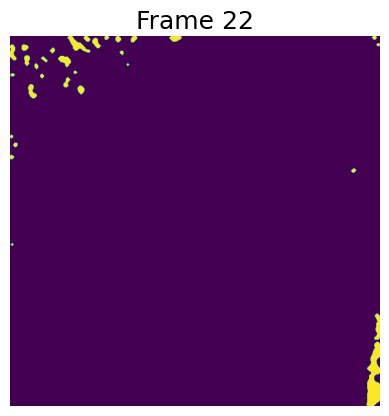

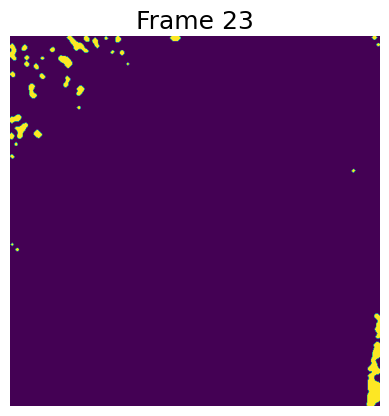

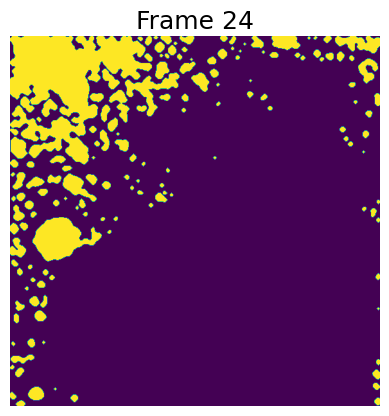

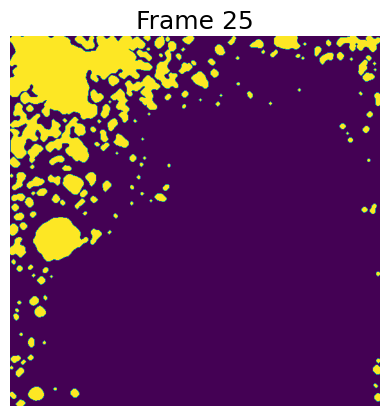

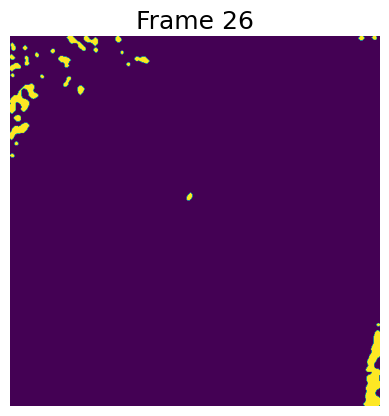

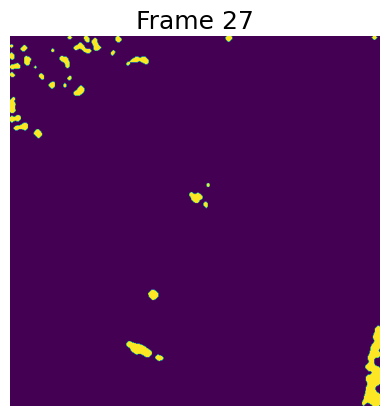

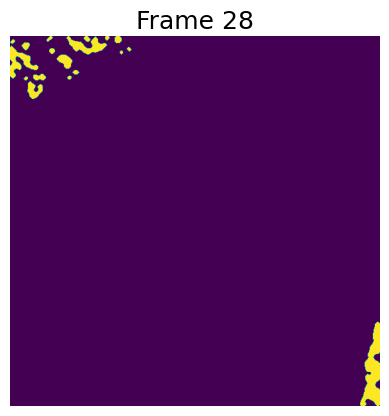

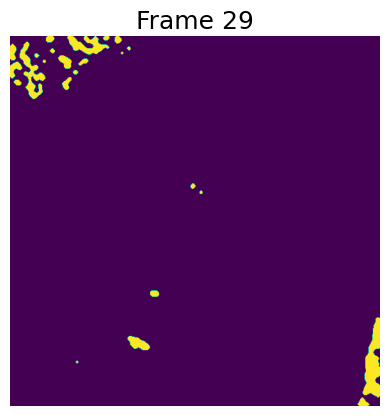

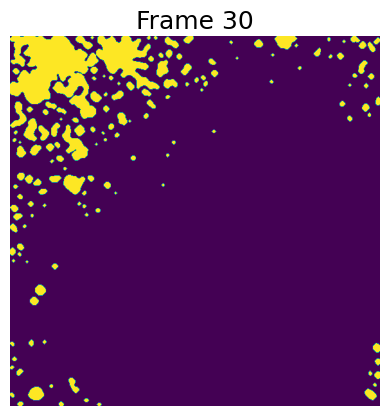

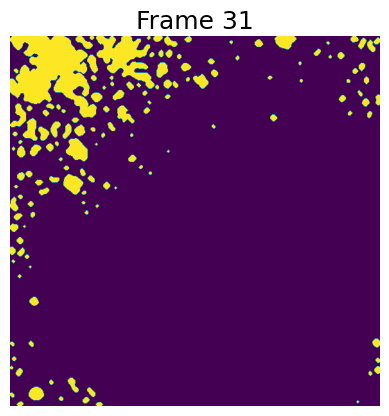

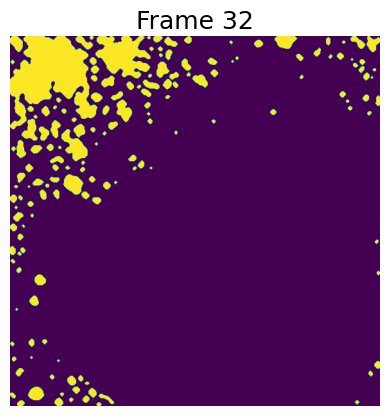

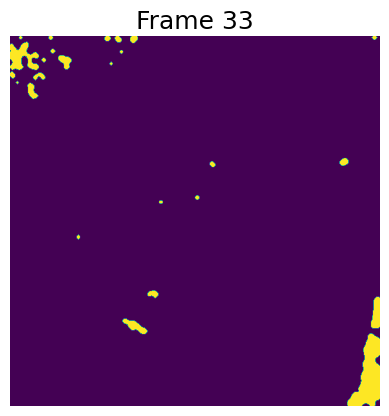

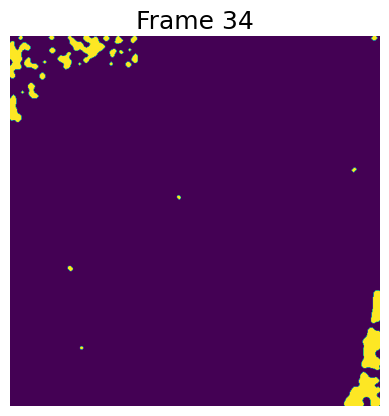

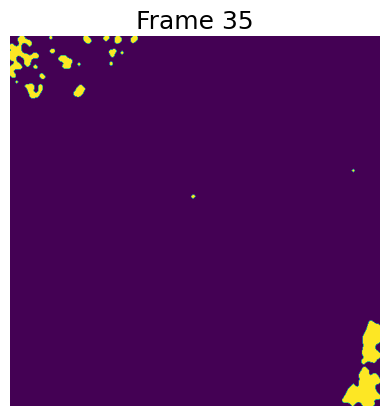

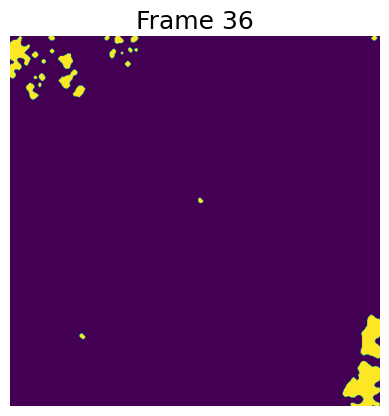

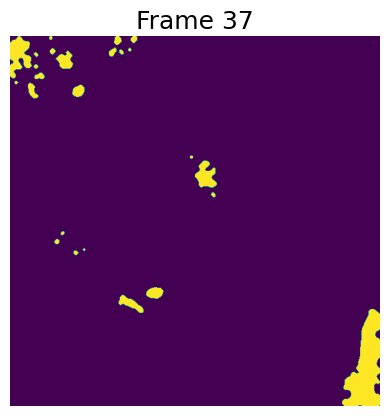

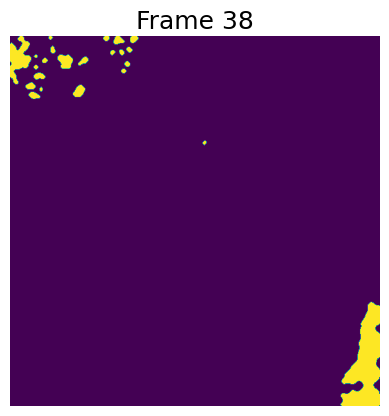

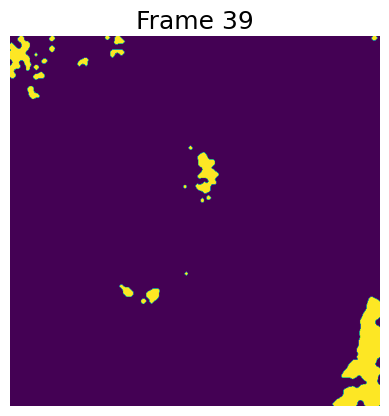

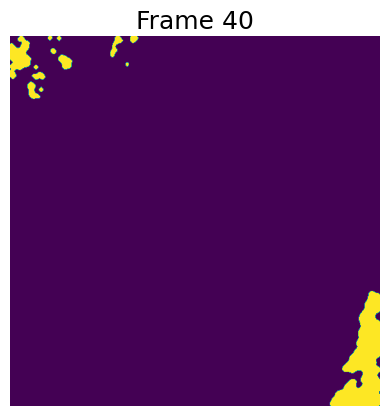

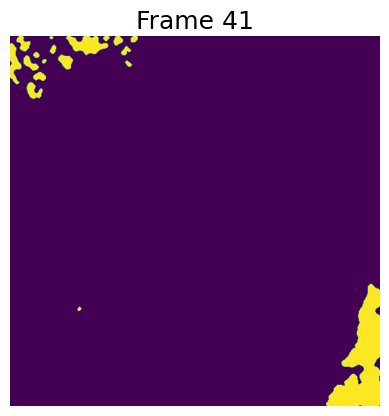

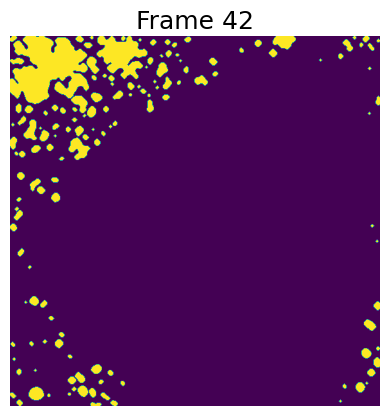

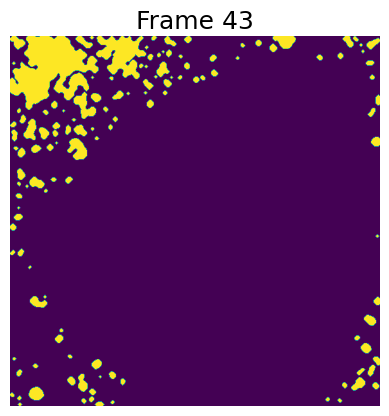

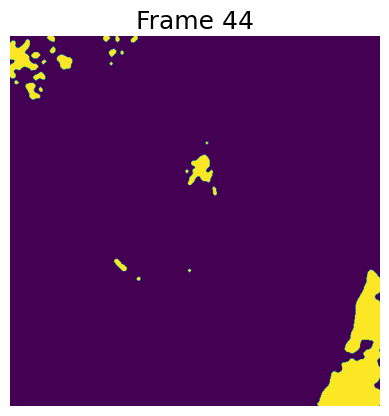

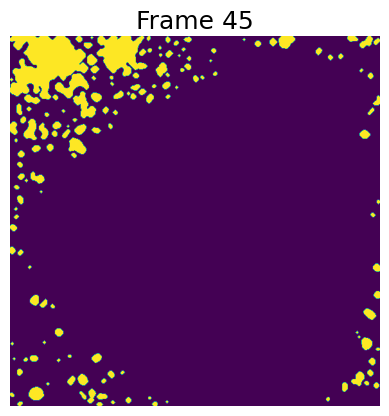

In [106]:
for i in range(np.shape(n)[0]):
    plt.imshow(n[i,...])
    plt.title(f'Frame {18+i}')
    plt.axis('off')
    plt.show()

From this we can get the position of all the algae plane per plane

### Making a gif for visualization

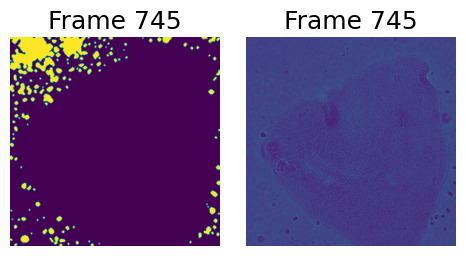

In [60]:
fig, ax = plt.subplots(1,2,figsize=(5, 5))
for a in ax:
    a.axis('off')
im = ax[0].imshow(n[0,...], interpolation='bilinear',animated = True)
over = ax[1].imshow(img[0,...], interpolation='bilinear')

fig.tight_layout()

def update(t):
    im.set_data(A_anim[t,...])
    over.set_data(A_anim_2[t,...])
    for a in ax:
        a.set_title(f'Frame {718+t}')
    return [im,over]


nb_times_im = np.shape(n)[0]

A_anim = n[::n.shape[0]//nb_times_im ,...]
A_anim_2 = img[::img.shape[0]//nb_times_im ,...]

anim = animation.FuncAnimation(fig, update,
                               frames=nb_times_im, interval=50, 
                               blit=True)
HTML(anim.to_jshtml())

In [133]:
f = r"../data/results/figures/drift_correction/animation_drift.gif" 
writergif = animation.PillowWriter(fps=1) 
anim.save(f, writer=writergif)

### Extracting the coordinate for each plane

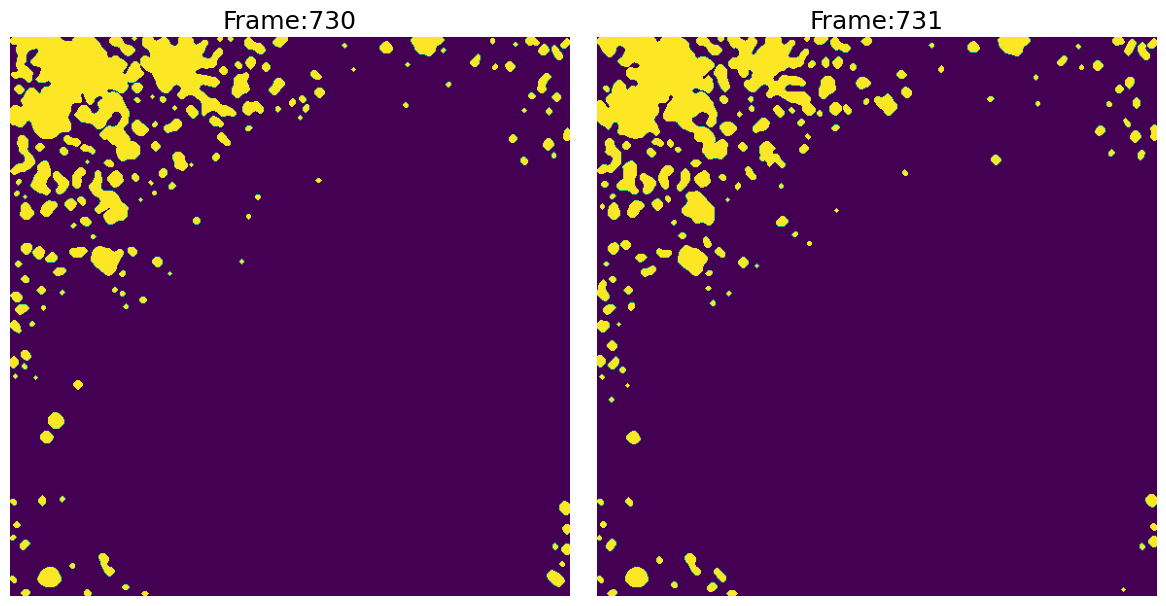

In [275]:
sns.set_context('talk')
m = plotting(1,2,n,[12,13])

title = [730,731]

for i,ax in enumerate(m):
    ax.set_title(f'Frame:{title[i]}')
    
    
#plt.savefig('../data/results/figures/drift_correction/drift_mask.png',dpi=300)

In [276]:
lab = label(n[12,...])
props = regionprops_table(label_image=lab, intensity_image = im_p, properties=('centroid','area','slice','intensity_mean'))

pos_1 = pd.DataFrame(props)
pos_1

centroid-0  centroid-1   area  \
0     48.312711   97.713222  14499   
1      9.530686  114.888087    277   
2      2.000000  127.500000     18   
3      2.346154  215.653846     26   
4      2.346154  226.346154     26   
..          ...         ...    ...   
143  558.500000    3.000000     42   
144  566.500000  118.500000     36   
145  572.109091   15.690909     55   
146  572.355556   79.333333     45   
147  573.000000  138.500000     28   

                                              slice  intensity_mean  
0        (slice(0, 129, None), slice(0, 233, None))       42.651645  
1       (slice(0, 21, None), slice(102, 129, None))       42.354043  
2        (slice(0, 5, None), slice(125, 131, None))       40.861667  
3        (slice(0, 6, None), slice(213, 219, None))       42.400000  
4        (slice(0, 6, None), slice(224, 230, None))       40.842308  
..                                              ...             ...  
143      (slice(555, 563, None), slice(0, 7, None))       38.987143  
144  (slice(564, 570, None), slice(115, 123, None))       43.217778  
145    (slice(569, 576, None), slice(11, 21, None))       42.141636  
146    (slice(569, 576, None), slice(76, 84, None))       45.628444  
147  (slice(571, 576, None), slice(135, 143, None))       38.642143  

[148 rows x 5 columns]

In [296]:
pos_3.index

Int64Index([  1,   2,   3,   4,   5,   7,   8,   9,  10,  11,
            ...
            137, 138, 139, 140, 142, 143, 144, 145, 146, 147],
           dtype='int64', length=140)

"\nfor i in range(len(pos_3.index)):\n    plt.text(pos_3.iloc[i]['centroid-1'],pos_3.iloc[i]['centroid-0'],i)\nplt.imshow(n[12,...])\nplt.show()\n"

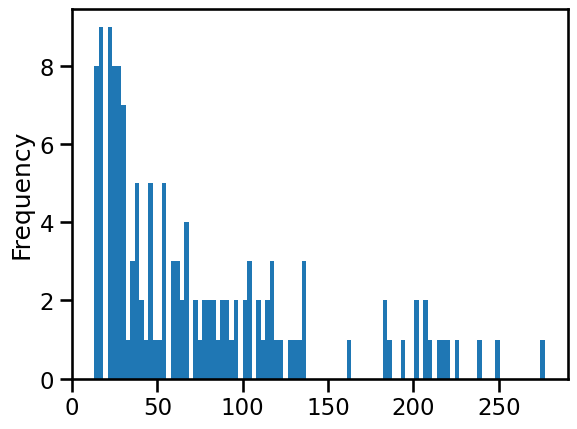

In [314]:
pos_3 = pos_1[pos_1.area < 300].reset_index()
#pos_3 = pos_1[pos_1.area > 300].reset_index()

pos_3.area.plot(kind='hist',bins=100)
'''
for i in range(len(pos_3.index)):
    plt.text(pos_3.iloc[i]['centroid-1'],pos_3.iloc[i]['centroid-0'],i)
plt.imshow(n[12,...])
plt.show()
'''


In [277]:
lab = label(n[13,...])
props = regionprops_table(label_image=lab, intensity_image = im_p, properties=('centroid','area','slice','intensity_mean'))

pos_2 = pd.DataFrame(props)
pos_2

centroid-0  centroid-1  area  \
0     54.868405   64.963049  9932   
1      9.537594  114.962406   266   
2      2.264706  127.000000    34   
3     32.861134  178.376609  3651   
4      2.346154  215.653846    26   
..          ...         ...   ...   
139  564.128205   79.128205    39   
140  566.575000  117.837500    80   
141  569.000000  541.000000    13   
142  572.263158   15.473684    57   
143  572.666667  138.500000    54   

                                              slice  intensity_mean  
0        (slice(0, 127, None), slice(0, 135, None))       42.548335  
1       (slice(0, 20, None), slice(102, 129, None))       42.284699  
2        (slice(0, 6, None), slice(124, 131, None))       41.399118  
3       (slice(0, 82, None), slice(134, 225, None))       42.671120  
4        (slice(0, 6, None), slice(213, 219, None))       42.400000  
..                                              ...             ...  
139    (slice(561, 568, None), slice(76, 83, None))       45.427179  
140  (slice(562, 572, None), slice(113, 124, None))       43.993500  
141  (slice(567, 572, None), slice(539, 544, None))       42.348462  
142    (slice(569, 576, None), slice(10, 21, None))       42.095439  
143  (slice(570, 576, None), slice(133, 145, None))       39.879259  

[144 rows x 5 columns]

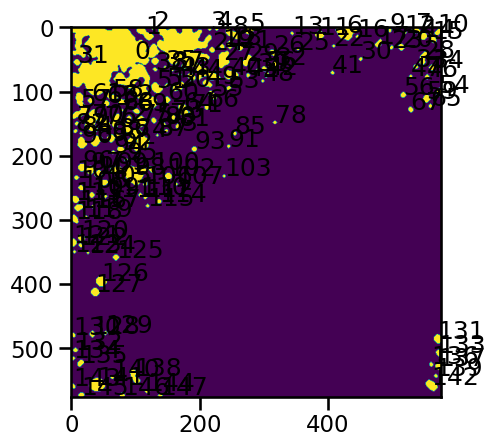

In [101]:
for i in pos_1.index.values:
    plt.text(pos_1.iloc[i]['centroid-1'],pos_1.iloc[i]['centroid-0'],i)
plt.imshow(n[12,...])
plt.show()

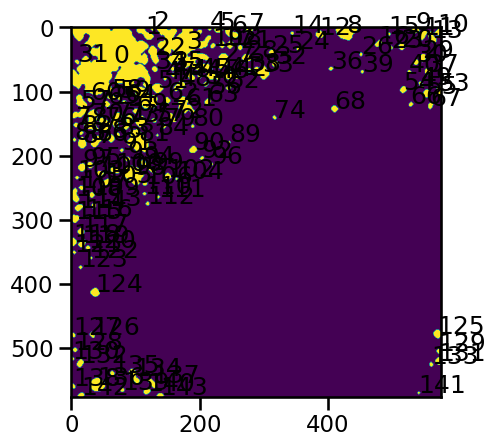

In [107]:
for i in pos_2.index.values:
    plt.text(pos_2.iloc[i]['centroid-1'],pos_2.iloc[i]['centroid-0'],i)
plt.imshow(n[13,...])
plt.show()

#### Compute the distance between the 2 (euclidian)

In [268]:
def dist(points):
    one = pos_1.iloc[points[0]]
    two = pos_2.iloc[points[1]]

    diff = (two['centroid-1']-one['centroid-1'])**2 + (two['centroid-0']-one['centroid-0'])**2
    dist = np.sqrt(diff)
    #print(f'The image moved {dist:.2f} pixels up')
    return dist    

In [269]:
po = [[131,125],[78,74],[67,66]]
d = []

for point in po:
    d.append(dist(point))

In [270]:
print(f'The image moved up with a drift of {np.mean(d):.2f} pixels with an error of {np.std(d):.2f} pixels')

The image moved up with a drift of 7.84 pixels with an error of 0.21 pixels


In [271]:
cost = np.array([[4, 1, 3], [2, 0, 5], [3, 2, 2]])
cost

array([[4, 1, 3],
       [2, 0, 5],
       [3, 2, 2]])

In [272]:
col = [131,78,67]
row = [125,66,74]
m = []

for i in row:
    for j in col:
        print(i,j)
        m.append(dist([j,i]))
        
m = np.asarray(m).reshape((3,3))

125 131
125 78
125 67
66 131
66 78
66 67
74 131
74 78
74 67


In [273]:
m

array([[  7.7511535 , 415.19657798, 351.71224407],
       [367.50914692, 213.56408912,   8.13766011],
       [428.06692431,   7.63822293, 212.37833686]])

In [274]:
from scipy.optimize import linear_sum_assignment

row_ind, col_ind = linear_sum_assignment(m)

print(row_ind)
print(col_ind)

[0 1 2]
[0 2 1]


The assignment works. Now we need a way to compute the optimal distances from the results of the assignment

In [190]:
for i,j in zip(row_ind,col_ind):
    print(row[i],col[j])

125 131
66 67
74 78


In [191]:
from scipy.sparse import csr_matrix

from scipy.sparse.csgraph import min_weight_full_bipartite_matching

In [192]:
biadjacency_matrix = csr_matrix(m)

In [193]:
print(min_weight_full_bipartite_matching(biadjacency_matrix))

(array([0, 1, 2]), array([0, 2, 1]))


Now we need a way to do the same operation for all points.And it needs to work for images that don't have the same number of points...

For that I will try:
- The linear sum assignment
- The min weight full bipartite matching

In [213]:
col = pos_2.index.values
row = pos_1.index.values
m = []

#'''
for i in row:
    for j in col:
        #print(i,j)
        m.append(dist([i,j]))
        
m = np.asarray(m).reshape((len(row),len(col)))

#'''

print(m.shape)

(148, 144)


In [214]:
row_ind, col_ind = linear_sum_assignment(m)

print(row_ind)
print(col_ind)

[  0   1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 140 141 142 143 144 145 146 147]
[  0   1   2   4   5   7   8   9   6  15  10  12  14  11  13  26  16  18
  17  20  21  36  23  19  24  25  27  29  28  39  31  32  30  37  22  33
  35  34  38  41  68   3  44  42  49  40  46  50  48  51  47  52  53  56
  54  57  58  55  43  60  59  65  61  67  63  66  64  69  70  45  71  72
  81  75  76  77  74  78  62  80  88  79  82  89  83  84  85  86  87  92
  91  90  73  93  97  95  98 100  99 101 102  96 1

In [222]:
biadjacency_matrix = csr_matrix(m)
r,c = min_weight_full_bipartite_matching(biadjacency_matrix)

In [224]:
d_1 = []
for i,j in zip(r,c):
    d_1.append(dist([row[i],col[j]]))
    
print(np.mean(d_1))
print(np.std(d_1))

9.830698767598198
15.66440270064815


In [225]:
d_2 = []
for i,j in zip(row_ind,col_ind):
    d_2.append(dist([row[i],col[j]]))
    
print(np.mean(d_2))
print(np.std(d_2))

8.667927643548751
15.839623908240231


Few observations:
- The two methods yield similar results
- The average drift is the same as when I computed between 3 relevant points (even if the sd is bigger) so it averages out
- the assignment is only keeping the lowest number of point (dimention of the matrix) so some points are not assigned and thus the assignment is not perfect hence a big sd...
- With this method I only compute the absolute value of the drift (because I'm taking the eucledian distance)
- If I want the direction of the distance I would need another measure ...

Let's make a function that computes everything all together

In [229]:
def dist(points):
    one = pos_1.iloc[points[0]]
    two = pos_2.iloc[points[1]]

    diff = (two['centroid-1']-one['centroid-1'])**2 + (two['centroid-0']-one['centroid-0'])**2
    dist = np.sqrt(diff)
    #print(f'The image moved {dist:.2f} pixels up')
    return dist 

def drift(row,col,method = 'linear'):
    '''
    Function to compute the drift between 2 time points.
    Workflow:
        - Create the distance matrix i.e. the "distance" between every point
        - perform linear sum assignment on this matrix
        - extract the best assignment and compute the 'optimal distance' between the assigned points    
    '''
    #Initialize the cost matrix
    m = []

    for t in row:
        for t_1 in col:
            m.append(dist([t,t_1])) #note that here the order of the arguments in the dist function matters 

    #reshape the matrix (might be a more efficient way to create it)
    
    m = np.asarray(m).reshape((len(row),len(col)))
    
    if method.lower() == 'linear':
        
        # Perform linear sum assignment

        row_ind, col_ind = linear_sum_assignment(m)
        
    elif method.lower() == 'bipartite':
        biadjacency_matrix = csr_matrix(m)
        
        row_ind,col_ind = min_weight_full_bipartite_matching(biadjacency_matrix)
   
    else:
        return 'Please input a valid method'
    
    # Initialize the optimal distance list
    
    distance = []
    
    # Besed on the result of the linear assignment compute it
    
    for i,j in zip(row_ind,col_ind):
        distance.append(dist([row[i],col[j]]))
        
    return distance

In [230]:
f = drift(pos_1.index.values,pos_2.index.values,'linear')

print(np.mean(f))
print(np.std(f))

8.667927643548751
15.839623908240231


In [231]:
f = drift(pos_1.index.values,pos_2.index.values,'bipartite')

print(np.mean(f))
print(np.std(f))

9.830698767598198
15.66440270064815


Compute the drift for more planes 

In [328]:
def dist(df_t,df_t1,points):
    one = df_t.iloc[points[0]]
    two = df_t1.iloc[points[1]]

    diff = (two['centroid-1']-one['centroid-1'])**2 + (two['centroid-0']-one['centroid-0'])**2
    dist = np.sqrt(diff)
    #print(f'The image moved {dist:.2f} pixels up')
    return dist 

def drift(df_t,df_t1,method = 'linear'):
    '''
    Function to compute the drift between 2 time points.
    Workflow:
        - Create the distance matrix i.e. the "distance" between every point
        - perform linear sum assignment on this matrix
        - extract the best assignment and compute the 'optimal distance' between the assigned points 
        
    Input: 
        - The 2 dataframes containing the position of all the algae for the 2 planes
        - the method to assign the objects default: linear
    '''
    #Initialize the cost matrix
    m = []
    
    row = df_t.index.values
    col = df_t1.index.values
    
    for t in row:
        for t_1 in col:
            m.append(dist(df_t,df_t1,[t,t_1])) #note that here the order of the arguments in the dist function matters 

    #reshape the matrix (might be a more efficient way to create it)
    
    m = np.asarray(m).reshape((len(row),len(col)))
    
    if method.lower() == 'linear':
        
        # Perform linear sum assignment

        row_ind, col_ind = linear_sum_assignment(m)
        
    elif method.lower() == 'bipartite':
        biadjacency_matrix = csr_matrix(m)
        
        row_ind,col_ind = min_weight_full_bipartite_matching(biadjacency_matrix)
   
    else:
        return 'Please input a valid method'
    
    # Initialize the optimal distance list
    
    distance = []
    
    # Besed on the result of the linear assignment compute it
    
    for i,j in zip(row_ind,col_ind):
        distance.append(dist(df_t,df_t1,[row[i],col[j]]))
        
    return distance


def global_drift(im,method = 'linear'):
    
    '''
    Function to compute the drift for a whole image plane per plane
    Workflow:
        - Loop over planes
        - compute the labels for the 2 images
        - call the drift computation function to extract the mean drift between plane t and t+1
        - append the mean drift of all points to a list
    Inputs:
        - the mask_image of all the algae for each time point
        - the method to map the points between 2 time points
    '''

    drif = []
    
    for plane in range(np.shape(im)[0]-1):
        
        lab = label(im[plane,...])
        props = regionprops_table(label_image=lab, properties=('centroid','area'))
        df_t = pd.DataFrame(props)
        
        # Filter the results to have plausible algae 
        # Here I am assuming that a "real algae" needs to have an area moe than 10 pixels² and less than 300
        
        df_t = df_t[df_t.area < 300].reset_index() #reset index to avoid having gaps in index value 
                                                #(it is used in the dist function)
        df_t = df_t[df_t.area > 10].reset_index()
        
        lab = label(im[plane+1,...])
        props = regionprops_table(label_image=lab, properties=('centroid','area'))
        df_t1 = pd.DataFrame(props) 
        df_t1 = df_t1[df_t1.area < 300].reset_index()
        df_t1 = df_t1[df_t1.area > 10].reset_index()
        
        
        drif.append(np.mean(drift(df_t,df_t1,method = 'linear')))
        
    return drif

In [263]:
test = n[10:15,...].copy()

drif = global_drift(test)

print(drif)

[10.091256261523178, 55.36892376714437, 8.667927643548751, 9.925877042109747]


In [329]:
test = n[10:15,...].copy()

drif = global_drift(test,'bipartite')

print(drif)

[10.16143193722102, 57.83671631174116, 8.070948656663427, 10.386750957762112]


#### New image with lateral drift

In [267]:
img = im[55:62,...]
ma = mask[55:62,...]

r = alg(img,ma)

drif = global_drift(r)

print(drif)

[23.099764566299584, 36.23379967468655, 31.533176945966048, 36.770911701972636, 24.161122105888, 3.2013059598803775]


In [330]:
img = im[55:62,...]
ma = mask[55:62,...]

r = alg(img,ma)

drif = global_drift(r)

print(drif)

[13.079362928522809, 44.1259986257513, 41.93729814906573, 50.73581669610456, 42.88430606688589, 0.619365196127853]


To verify this result I used ImageJ: 
- Compute the centroid of an algae at time t
- Compute the centroid of the same algae at time t+1
- Make the difference and call it drift